In [97]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from fractal_noise import get_fractal_noise

0.0 1.0
2.0 0.0


MovieWriter imagemagick unavailable; using Pillow instead.


1.0 0.0


MovieWriter imagemagick unavailable; using Pillow instead.


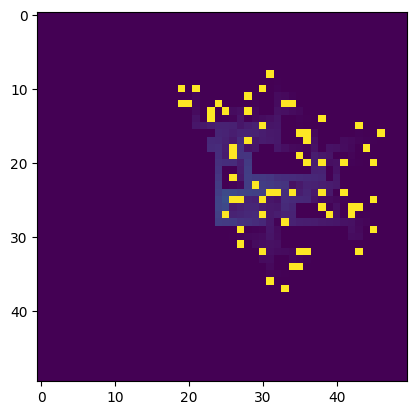

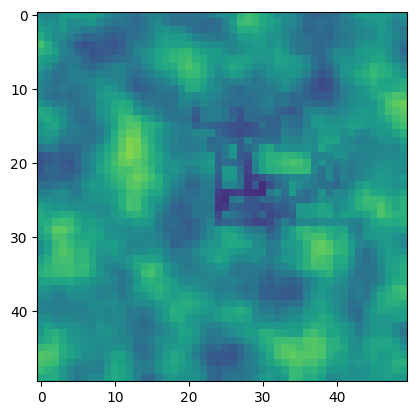

In [122]:
dir_to_vector = {
    0: np.array([0, 1]),    # up
    1: np.array([1, 0]),    # right
    2: np.array([0, -1]),   # down
    3: np.array([-1, 0])    # left
}

lr = {
    "UP": 0,
    "RIGHT": 1,
    "DOWN": 2,
    "LEFT": 3
}

def normalize(value, prev_lower, prev_upper, lower, upper):
    return (value - prev_lower) / (prev_upper - prev_lower) * (upper - lower) + lower

class Fungus:
    def __init__(self, greed=0.01):
        self.fungus = 0
        self.greed = greed
        self.connections = set()

    def update(self, grid, x, y):
        diff = self.greed if grid[x, y].substrate > self.greed else grid[x, y].substrate
        grid[x, y].substrate -= diff
        grid[x, y].content.fungus += diff
        if(grid[x, y].substrate < 0):
            grid[x, y].substrate = 0
        if(self.fungus > 1):
            self.fungus = 1


class Hyphae():
    def __init__(self, direction):
        self.direction = direction

    def to_global(self, direction):
        return (self.direction + direction) % 4

    def update(self, grid, x, y, distance = 0.5):
        movements = [
            (np.random.rand() < distance * normalize(grid[x,y].substrate, 0, 1, 0.5, 1), lr["UP"]),   # relative forward
            (np.random.rand() < distance**2 * normalize(grid[x,y].substrate, 0, 1, 0.5, 1), lr["LEFT"]),       # relative left
            (np.random.rand() < distance**2 * normalize(grid[x,y].substrate, 0, 1, 0.5, 1), lr["RIGHT"])       # relative right
        ]

        has_moved = False
        dirs = []
        for m in movements:
            if m[0]:
                m_direction = self.to_global(m[1])
                dirs.append(m_direction)
                pos = np.array([x, y]) + dir_to_vector[m_direction]
                if(pos[0] < 0 or pos[0] >= grid.shape[0] or pos[1] < 0 or pos[1] >= grid.shape[1]):
                    # print(".", end="")
                    pass
                elif grid[pos[0], pos[1]].content is None:
                    grid[pos[0], pos[1]].content = Hyphae(m_direction)
                    has_moved = True
        if has_moved:
            fungus = Fungus(0.01)
            for d in dirs:
                fungus.connections.add(d)
            grid[x, y].content = fungus




class Cell:
    def __init__(self, substrate):
        self.substrate = substrate
        self.content = None

    def update(self, grid, x, y):
        if self.content is not None:
            self.content.update(grid, x, y)



class Grid:
    def __init__(self, size=100):
        noise = get_fractal_noise(size, size, 0.5, [2, 10])
        noise = normalize(noise, np.min(noise), np.max(noise), 0, 1)
        print(np.min(noise), np.max(noise))
        self.grid = np.array([[Cell(noise[i, j]) for j in range(size)] for i in range(size)])
        self.grid[size//2, size//2].content = Hyphae(0)
        self.fungus_images = []
        self.substrate_images = []

    def fungus_to_image(self):
        image = np.zeros(self.grid.shape)
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                c = self.grid[i, j].content
                image[i, j] = 0 if c is None else c.fungus if isinstance(c, Fungus) else 2
        return image
    
    def substrate_to_image(self):
        image = np.zeros(self.grid.shape)
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                image[i, j] = self.grid[i, j].substrate
        return image
    
    def substrate_movement(self, new_grid, multiplier=0.01):
        for i in range(self.grid.shape[0] - 1):
            for j in range(self.grid.shape[1]):
                diff = multiplier * (self.grid[i, j].substrate - self.grid[i+1, j].substrate)
                new_grid[i, j].substrate -= diff
                new_grid[i+1, j].substrate += diff

                ij_c = self.grid[i, j].content
                ip1j_c = self.grid[i+1, j].content
                if isinstance(ij_c, Fungus) \
                        and isinstance(ip1j_c, Fungus) \
                        and lr["RIGHT"] in ij_c.connections \
                        and lr["LEFT"] in ip1j_c.connections:
                    diff = multiplier * (self.grid[i, j].content.fungus - self.grid[i+1, j].content.fungus)
                    new_grid[i, j].content.fungus -= diff
                    new_grid[i+1, j].content.fungus += diff

        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1] - 1):
                diff = multiplier * (self.grid[i, j].substrate - self.grid[i, j+1].substrate)
                new_grid[i, j].substrate -= diff
                new_grid[i, j+1].substrate += diff
                
                ij_c = self.grid[i, j].content
                ijp1_c = self.grid[i, j+1].content
                if isinstance(ij_c, Fungus) \
                        and isinstance(ijp1_c, Fungus) \
                        and lr["DOWN"] in ij_c.connections \
                        and lr["UP"] in ijp1_c.connections:
                    diff = multiplier * (self.grid[i, j].content.fungus - self.grid[i, j+1].content.fungus)
                    new_grid[i, j].content.fungus -= diff
                    new_grid[i, j+1].content.fungus += diff

    def run(self, steps=20):
        self.fungus_images.append(self.fungus_to_image())
        self.substrate_images.append(self.substrate_to_image())

        for s in range(steps):
            new_grid = copy.deepcopy(self.grid)
            self.grid = self.substrate_movement(new_grid)
            
            self.grid = new_grid
            new_grid = copy.deepcopy(self.grid)


            for i in range(self.grid.shape[0]):
                for j in range(self.grid.shape[1]):
                    self.grid[i, j].update(new_grid, i, j)
            
            self.grid = new_grid
            self.fungus_images.append(self.fungus_to_image())
            self.substrate_images.append(self.substrate_to_image())

    def animate(self, images, fileName):
        fig, ax = plt.subplots()
        ims = []
        max_value = max([np.max(image) for image in images])
        min_value = min([np.min(image) for image in images])
        print(max_value, min_value)
        for image in images:
            im = ax.imshow(image, animated=True, vmin=0, vmax=max_value)
            ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000, repeat=True)
        ani.save(f'{fileName}.gif', writer='imagemagick')

    def generate_gifs(self):
        self.animate(self.fungus_images, "fungus")
        self.animate(self.substrate_images, "substrate")

        


    


grid = Grid(50)
grid.run(50)
grid.generate_gifs()


# hyphae cost
# translocation cost